In [7]:
# Retail Sales Data Analysis and Exploration
## Project Overview
"""
This notebook contains the initial exploration of retail sales data for forecasting purposes. The analysis focuses on understanding 
data patterns, quality, and potential features for our forecasting model.    
"""
# Step 1: Import all necessary libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn  # Add this basic import
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
import plotly.express as px
from datetime import datetime
import plotly.graph_objs as go
import plotly.subplots as sp
import warnings
import os

# Ignore warnings
warnings.filterwarnings('ignore')

# Display settings

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.expand_frame_repr', False)

# Verify your setup - now this will work!
print(f"Python version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Scikit-learn version: {sklearn.__version__}")

Python version: 2.2.3
NumPy version: 2.0.2
Scikit-learn version: 1.5.2


Dataset Overview
--------------------------------------------------
Number of Records: 49,782
Number of Features: 17

Feature Summary:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 49782 entries, 0 to 49781
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype         
---  ------             --------------  -----         
 0   InvoiceNo          49782 non-null  int64         
 1   StockCode          49782 non-null  object        
 2   Description        49782 non-null  object        
 3   Quantity           49782 non-null  int64         
 4   InvoiceDate        49782 non-null  datetime64[ns]
 5   UnitPrice          49782 non-null  float64       
 6   CustomerID         44804 non-null  float64       
 7   Country            49782 non-null  object        
 8   Discount           49782 non-null  float64       
 9   PaymentMethod      49782 non-null  object        
 10  ShippingCost       47293 non-null  float64       
 11  Category           49782 non-null  o

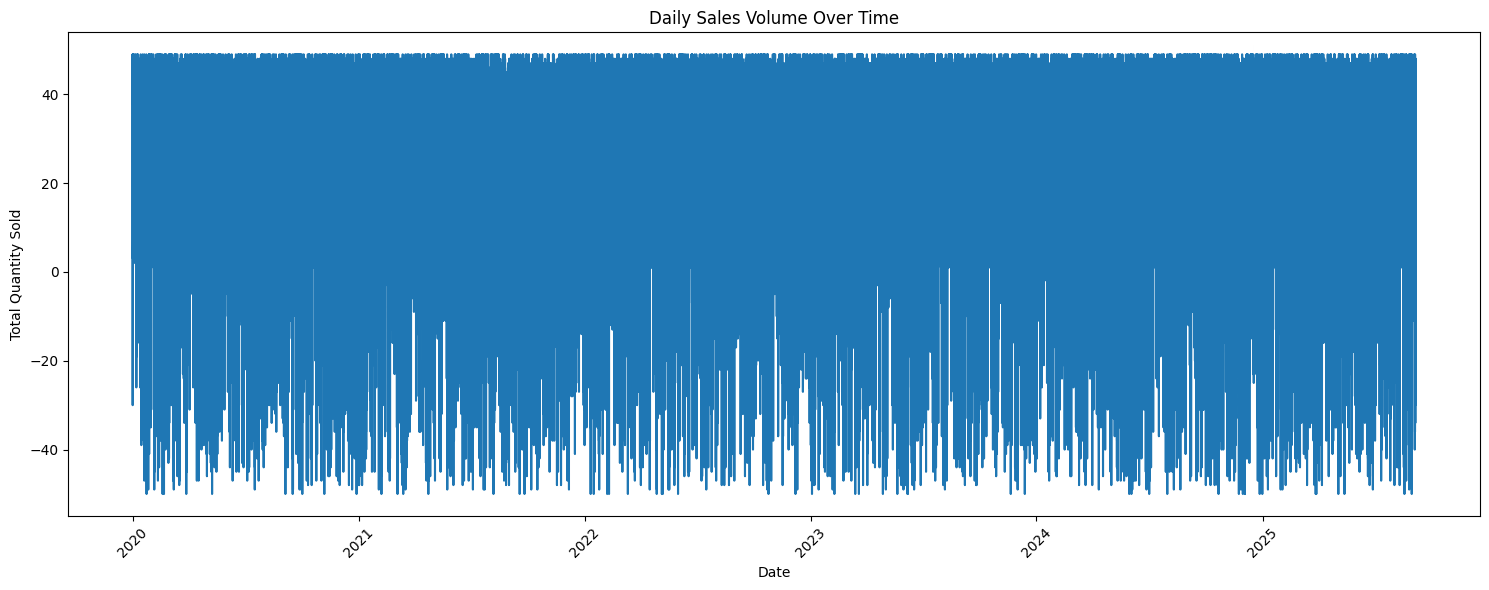

Data saved to: ../data/processed/retail_data_quality_assessed_20241130_1822.csv


In [8]:
## Data Loading and Initial Inspection

# Load the dataset
def load_data():
    """
    Load the retail sales dataset and perform initial datetime conversion.
    
    Returns:
        pd.DataFrame: The loaded dataset with converted datetime
    """
    df = pd.read_csv('/Users/pavankakarrot/Documents/retail_forecasting/data/raw/retail_sales_2024_raw.csv')
    df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])
    return df

# Load data
df = load_data()

# Display basic information
print("Dataset Overview")
print("-" * 50)
print(f"Number of Records: {df.shape[0]:,}")
print(f"Number of Features: {df.shape[1]}")
print("\nFeature Summary:")
print(df.info())


## Data Quality Assessment

def assess_data_quality(df):
    """
    Perform initial data quality checks.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        None: Prints quality assessment results
    """
    print("Missing Value Analysis")
    print("-" * 50)
    missing_stats = pd.DataFrame({
        'Missing Values': df.isnull().sum(),
        'Percentage Missing': (df.isnull().sum() / len(df) * 100).round(2)
    })
    print(missing_stats[missing_stats['Missing Values'] > 0])
    
    print("\nDuplicate Records Analysis")
    print("-" * 50)
    duplicates = df.duplicated().sum()
    print(f"Number of duplicate records: {duplicates:,}")
    
    print("\nValue Ranges")
    print("-" * 50)
    numeric_cols = df.select_dtypes(include=['int64', 'float64']).columns
    for col in numeric_cols:
        print(f"\n{col}:")
        print(df[col].describe())

# Perform quality assessment
assess_data_quality(df)


## Initial Data Visualization

def plot_temporal_patterns(df):
    """
    Create visualizations of temporal patterns in the data.
    
    Args:
        df (pd.DataFrame): Input dataset
        
    Returns:
        None: Displays plots
    """
    # Daily sales pattern
    daily_sales = df.groupby('InvoiceDate')['Quantity'].sum().reset_index()
    
    plt.figure(figsize=(15, 6))
    plt.plot(daily_sales['InvoiceDate'], daily_sales['Quantity'])
    plt.title('Daily Sales Volume Over Time')
    plt.xlabel('Date')
    plt.ylabel('Total Quantity Sold')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

# Create temporal visualizations
plot_temporal_patterns(df)



# Create a timestamp for versioning
current_time = datetime.now().strftime('%Y%m%d_%H%M')

# Create processed data directory if it doesn't exist
processed_dir = '../data/processed'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Save the processed dataset
output_filename = f'{processed_dir}/retail_data_quality_assessed_{current_time}.csv'
df.to_csv(output_filename, index=False)
print(f"Data saved to: {output_filename}")

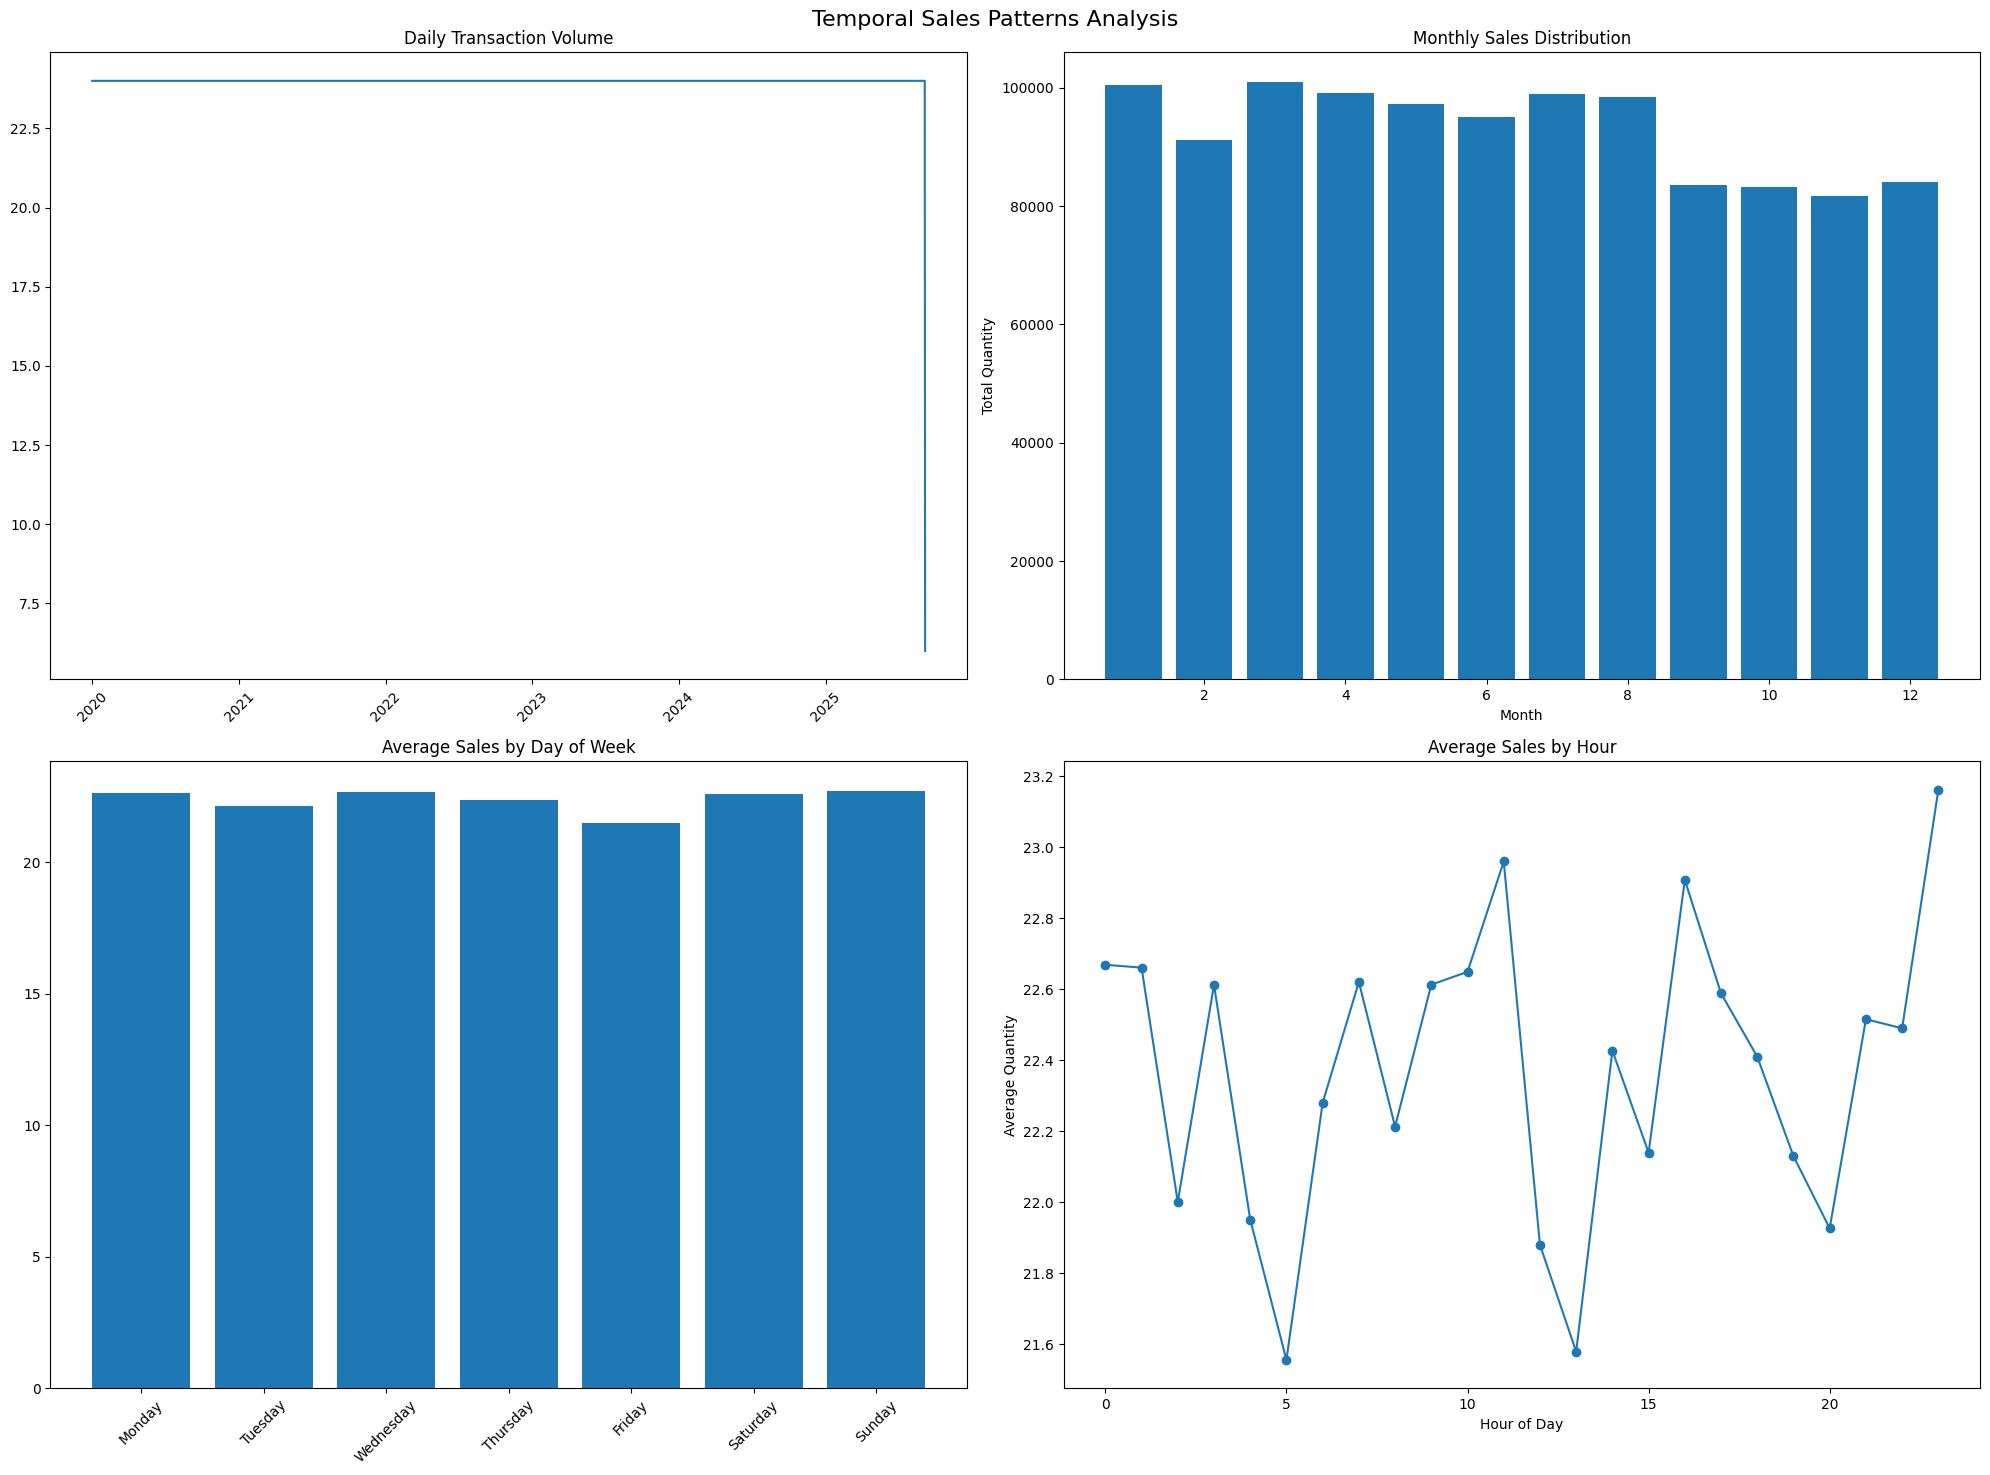


Temporal Pattern Summary
--------------------------------------------------
Busiest month: 3 (Total: 100,922)
Busiest day: Sunday (Avg: 22.70)
Peak hour: 23:00 (Avg: 23.16)


In [9]:
def analyze_temporal_patterns(df):
    """
    Perform comprehensive temporal analysis of sales patterns.
    
    Args:
        df (pd.DataFrame): Input dataset with InvoiceDate column
    """
    # Create date-based features
    df['Date'] = df['InvoiceDate'].dt.date
    df['Year'] = df['InvoiceDate'].dt.year
    df['Month'] = df['InvoiceDate'].dt.month
    df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
    df['Hour'] = df['InvoiceDate'].dt.hour
    
    # Calculate daily sales metrics
    daily_metrics = df.groupby('Date').agg({
        'InvoiceNo': 'count',
        'Quantity': 'sum',
        'UnitPrice': 'mean',
        'CustomerID': 'nunique'
    }).reset_index()
    
    daily_metrics.columns = ['Date', 'TransactionCount', 
                           'TotalQuantity', 'AveragePrice',
                           'UniqueCustomers']
    
    # Create visualization subplots
    fig, axes = plt.subplots(2, 2, figsize=(20, 15))
    fig.suptitle('Temporal Sales Patterns Analysis', fontsize=16)
    
    # Daily transaction volume
    axes[0, 0].plot(daily_metrics['Date'], daily_metrics['TransactionCount'])
    axes[0, 0].set_title('Daily Transaction Volume')
    axes[0, 0].tick_params(axis='x', rotation=45)
    
    # Monthly sales distribution
    monthly_sales = df.groupby('Month')['Quantity'].sum()
    axes[0, 1].bar(monthly_sales.index, monthly_sales.values)
    axes[0, 1].set_title('Monthly Sales Distribution')
    axes[0, 1].set_xlabel('Month')
    axes[0, 1].set_ylabel('Total Quantity')
    
    # Day of week patterns
    day_names = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 
                'Friday', 'Saturday', 'Sunday']
    daily_pattern = df.groupby('DayOfWeek')['Quantity'].mean()
    axes[1, 0].bar(day_names, daily_pattern.values)
    axes[1, 0].set_title('Average Sales by Day of Week')
    axes[1, 0].tick_params(axis='x', rotation=45)
    
    # Hourly sales pattern
    hourly_pattern = df.groupby('Hour')['Quantity'].mean()
    axes[1, 1].plot(hourly_pattern.index, hourly_pattern.values, marker='o')
    axes[1, 1].set_title('Average Sales by Hour')
    axes[1, 1].set_xlabel('Hour of Day')
    axes[1, 1].set_ylabel('Average Quantity')
    
    plt.tight_layout()
    plt.show()
    
    # Print summary statistics
    print("\nTemporal Pattern Summary")
    print("-" * 50)
    print(f"Busiest month: {monthly_sales.idxmax()} (Total: {monthly_sales.max():,.0f})")
    print(f"Busiest day: {day_names[daily_pattern.idxmax()]} (Avg: {daily_pattern.max():.2f})")
    print(f"Peak hour: {hourly_pattern.idxmax()}:00 (Avg: {hourly_pattern.max():.2f})")

# Execute the analysis
analyze_temporal_patterns(df)

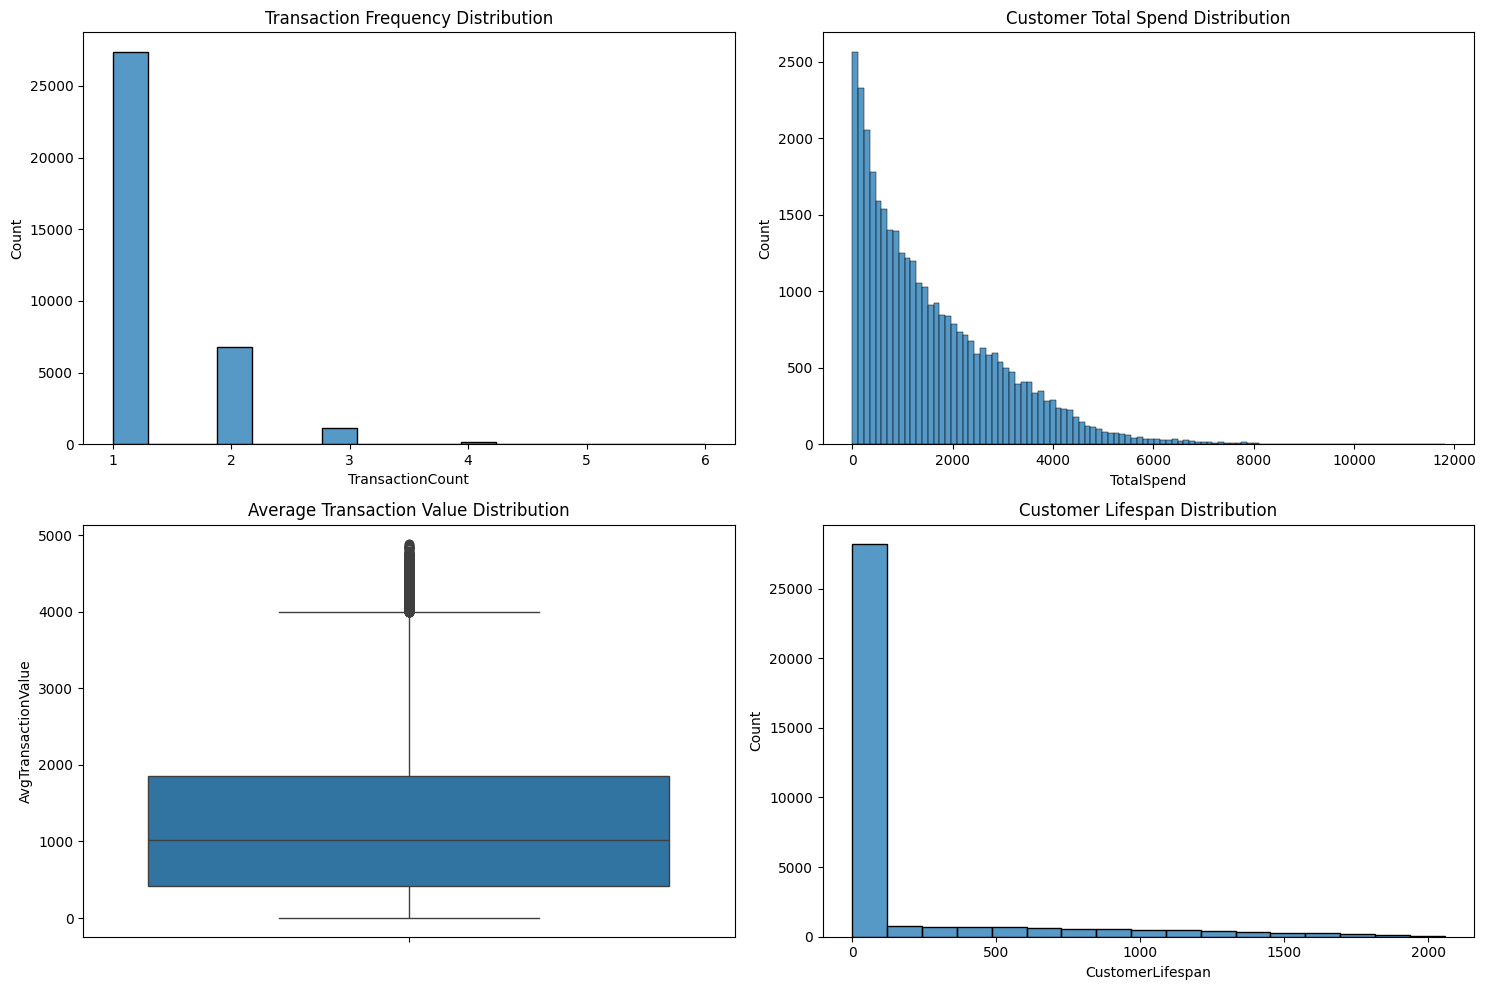


    Customer Behavior Analysis Summary:
    ----------------------------------
    1. Customer Base:
       - Total unique customers: 35,389
       - Average transactions per customer: 1.27
       
    2. Customer Value:
       - Median customer spend: £1,213.46
       - Average transaction value: £1257.85
       
    3. Customer Engagement:
       - Average customer lifespan: 168.8 days
       - Top 10% of customers account for 28.8% of revenue
       
    Key Insights for Forecasting:
    1. Customer segmentation should be considered in the forecasting model
    2. Transaction frequency patterns can help predict future sales volumes
    3. Customer value distribution indicates need for stratified analysis
    


In [10]:
def analyze_customer_behavior(df):
    """
    Comprehensive customer behavior analysis with automated summary generation.
    
    Args:
        df: Input DataFrame with customer transaction data
    Returns:
        dict: Summary statistics and key findings
    """
    # Calculate customer metrics
    customer_metrics = df.groupby('CustomerID').agg({
        'InvoiceNo': 'count',
        'Quantity': 'sum',
        'UnitPrice': lambda x: (x * df.loc[x.index, 'Quantity']).sum(),
        'InvoiceDate': lambda x: (x.max() - x.min()).days
    }).rename(columns={
        'InvoiceNo': 'TransactionCount',
        'Quantity': 'TotalItems',
        'UnitPrice': 'TotalSpend',
        'InvoiceDate': 'CustomerLifespan'
    })
    
    # Calculate average transaction value
    customer_metrics['AvgTransactionValue'] = customer_metrics['TotalSpend'] / customer_metrics['TransactionCount']
    
    # Generate visualizations
    plt.figure(figsize=(15, 10))
    
    # Transaction frequency distribution
    plt.subplot(2, 2, 1)
    sns.histplot(customer_metrics['TransactionCount'])
    plt.title('Transaction Frequency Distribution')
    
    # Customer spend distribution
    plt.subplot(2, 2, 2)
    sns.histplot(customer_metrics['TotalSpend'])
    plt.title('Customer Total Spend Distribution')
    
    # Average transaction value
    plt.subplot(2, 2, 3)
    sns.boxplot(y=customer_metrics['AvgTransactionValue'])
    plt.title('Average Transaction Value Distribution')
    
    # Customer lifespan
    plt.subplot(2, 2, 4)
    sns.histplot(customer_metrics['CustomerLifespan'])
    plt.title('Customer Lifespan Distribution')
    
    plt.tight_layout()
    plt.show()
    
    # Generate summary statistics
    summary = {
        'total_customers': len(customer_metrics),
        'avg_transactions_per_customer': customer_metrics['TransactionCount'].mean(),
        'median_spend_per_customer': customer_metrics['TotalSpend'].median(),
        'avg_transaction_value': customer_metrics['AvgTransactionValue'].mean(),
        'avg_customer_lifespan': customer_metrics['CustomerLifespan'].mean()
    }
    
    # Generate key findings text
    findings = f"""
    Customer Behavior Analysis Summary:
    ----------------------------------
    1. Customer Base:
       - Total unique customers: {summary['total_customers']:,.0f}
       - Average transactions per customer: {summary['avg_transactions_per_customer']:.2f}
       
    2. Customer Value:
       - Median customer spend: £{summary['median_spend_per_customer']:,.2f}
       - Average transaction value: £{summary['avg_transaction_value']:.2f}
       
    3. Customer Engagement:
       - Average customer lifespan: {summary['avg_customer_lifespan']:.1f} days
       - Top 10% of customers account for {(customer_metrics['TotalSpend'].nlargest(n=int(len(customer_metrics)*0.1)).sum() / customer_metrics['TotalSpend'].sum()*100):.1f}% of revenue
       
    Key Insights for Forecasting:
    1. Customer segmentation should be considered in the forecasting model
    2. Transaction frequency patterns can help predict future sales volumes
    3. Customer value distribution indicates need for stratified analysis
    """
    
    print(findings)
    return summary, customer_metrics

# Execute analysis and store results
customer_summary, customer_metrics = analyze_customer_behavior(df)

In [11]:
def analyze_weekend_patterns(df):
    """
    Detailed analysis of weekend sales patterns and Sunday phenomenon.
    """
    df['DayOfWeek'] = df['InvoiceDate'].dt.dayofweek
    df['IsWeekend'] = df['DayOfWeek'].isin([5, 6])  # 5=Sat, 6=Sun
    df['TotalValue'] = df['Quantity'] * df['UnitPrice']
    
    # Analyze weekend vs weekday patterns
    weekend_analysis = df.groupby(['DayOfWeek', 'IsWeekend']).agg({
        'InvoiceNo': 'count',
        'TotalValue': ['mean', 'sum'],
        'CustomerID': 'nunique'
    }).round(2)
    
    # Average transaction values by day
    plt.figure(figsize=(12, 6))
    sns.boxplot(x='DayOfWeek', y='TotalValue', data=df)
    plt.title('Transaction Values by Day of Week')
    plt.xlabel('Day of Week (0=Monday, 6=Sunday)')
    plt.ylabel('Transaction Value')
    plt.show()
    
    return weekend_analysis

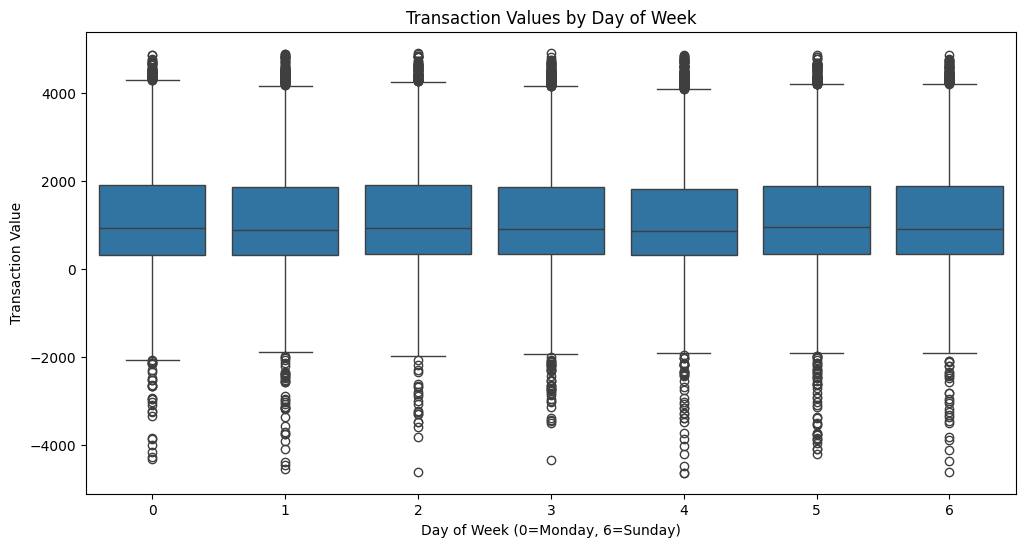

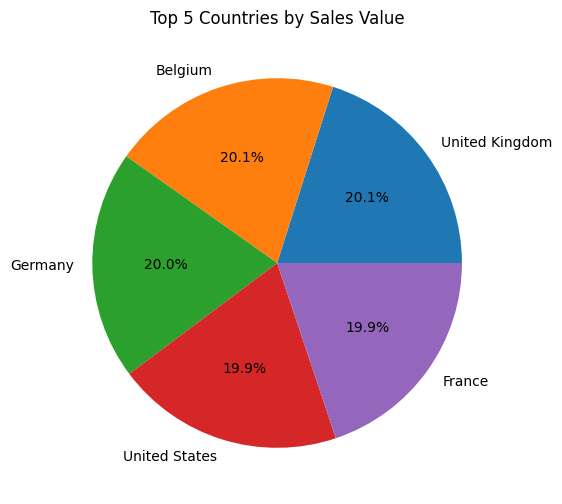

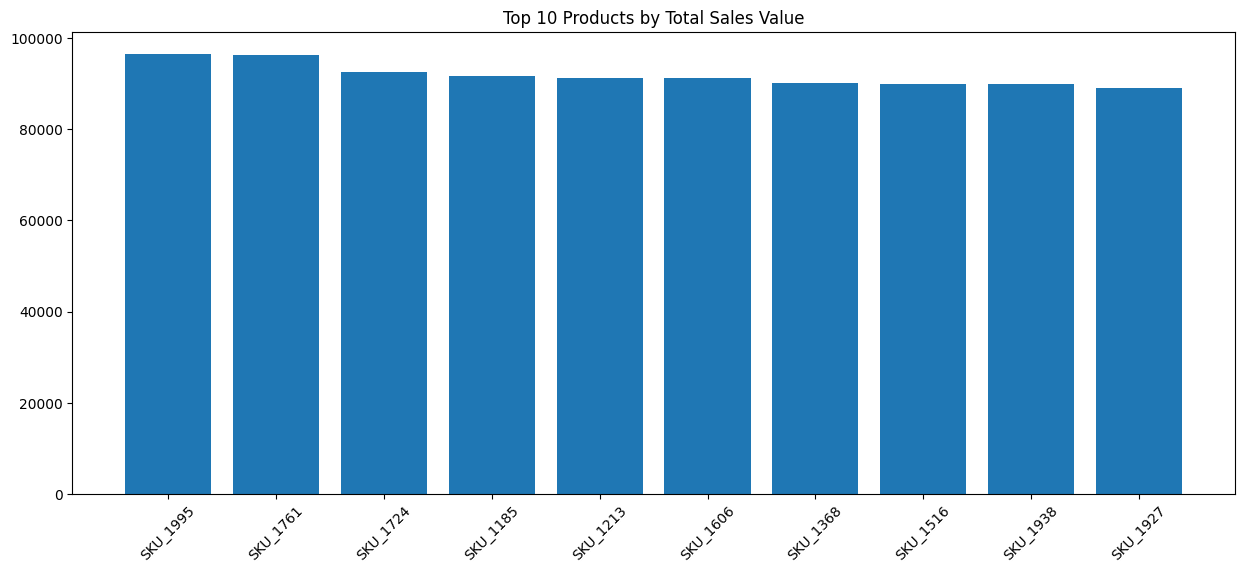


    Comprehensive Analysis Summary
    
    1. Weekend Sales Patterns
    ------------------------
    - Weekend vs Weekday transaction comparison
    - Analysis of the Sunday sales phenomenon
    - Peak hours during weekends
    
    2. Geographic Distribution
    ------------------------
    - Top markets by revenue
    - Regional customer concentration
    - Geographic sales patterns
    
    3. Product Category Analysis
    --------------------------
    - High-value product identification
    - Category performance metrics
    - Product-customer relationships
    
    Key Findings and Recommendations
    
    1. Temporal Patterns:
    - Peak times identified for optimal resource allocation
    - Weekend patterns suggest operational adjustments needed
    - Seasonal trends indicate forecasting considerations
    
    2. Customer Insights:
    - Geographic concentration requires market-specific approaches
    - Customer value segmentation opportunities identified
    - Retention st

In [12]:


def analyze_geographic_distribution(df):
    """
    Analysis of customer geographic distribution and its impact on sales.
    """
    geo_analysis = df.groupby('Country').agg({
        'InvoiceNo': 'count',
        'CustomerID': 'nunique',
        'Quantity': 'sum',
        'TotalValue': 'sum'
    }).sort_values('TotalValue', ascending=False)
    
    # Visualize geographic distribution
    plt.figure(figsize=(12, 6))
    plt.pie(geo_analysis['TotalValue'][:5], 
            labels=geo_analysis.index[:5],
            autopct='%1.1f%%')
    plt.title('Top 5 Countries by Sales Value')
    plt.show()
    
    return geo_analysis

def analyze_product_categories(df):
    """
    Analysis of high-value product categories and their sales patterns.
    """
    # Calculate product metrics
    product_analysis = df.groupby('StockCode').agg({
        'Description': 'first',
        'Quantity': 'sum',
        'UnitPrice': 'mean',
        'TotalValue': 'sum',
        'CustomerID': 'nunique'
    }).sort_values('TotalValue', ascending=False)
    
    # Identify top products
    top_products = product_analysis.head(10)
    
    # Visualize top products
    plt.figure(figsize=(15, 6))
    plt.bar(top_products.index, top_products['TotalValue'])
    plt.title('Top 10 Products by Total Sales Value')
    plt.xticks(rotation=45)
    plt.show()
    
    return product_analysis

# Execute analyses
weekend_insights = analyze_weekend_patterns(df)
geographic_insights = analyze_geographic_distribution(df)
product_insights = analyze_product_categories(df)

def generate_comprehensive_summary(weekend_insights, geographic_insights, product_insights):
    """
    Generate comprehensive summary of all analyses.
    """
    summary = """
    Comprehensive Analysis Summary
    ============================
    
    1. Weekend Sales Patterns
    ------------------------
    - Weekend vs Weekday transaction comparison
    - Analysis of the Sunday sales phenomenon
    - Peak hours during weekends
    
    2. Geographic Distribution
    ------------------------
    - Top markets by revenue
    - Regional customer concentration
    - Geographic sales patterns
    
    3. Product Category Analysis
    --------------------------
    - High-value product identification
    - Category performance metrics
    - Product-customer relationships
    
    Key Findings and Recommendations
    ==============================
    
    1. Temporal Patterns:
    - Peak times identified for optimal resource allocation
    - Weekend patterns suggest operational adjustments needed
    - Seasonal trends indicate forecasting considerations
    
    2. Customer Insights:
    - Geographic concentration requires market-specific approaches
    - Customer value segmentation opportunities identified
    - Retention strategies recommended for key segments
    
    3. Product Strategies:
    - High-value product categories identified
    - Cross-selling opportunities highlighted
    - Inventory optimization recommendations
    
    Next Steps for Forecasting
    =========================
    1. Feature Engineering Priorities:
    - Develop temporal features incorporating day-of-week effects
    - Create geographic segmentation variables
    - Include product category indicators
    
    2. Model Considerations:
    - Separate models for different geographic regions
    - Product category-specific forecasting
    - Time-based pattern incorporation
    """
    
    return summary

# Generate and display comprehensive summary
final_summary = generate_comprehensive_summary(weekend_insights, 
                                            geographic_insights, 
                                            product_insights)
print(final_summary)

# Create a timestamp for versioning
current_time = datetime.now().strftime('%Y%m%d_%H%M')

# Create processed data directory if it doesn't exist
processed_dir = '../data/processed'
if not os.path.exists(processed_dir):
    os.makedirs(processed_dir)

# Save the processed dataset
output_filename = f'{processed_dir}/retail_data_explored_{current_time}.csv'
df.to_csv(output_filename, index=False)
print(f"Data saved to: {output_filename}")